## Introduction

This notebook implements a Convolutional Neural Network (CNN) from scratch to perform image classification on the CIFAR-10 dataset. CIFAR-10 is a widely used benchmark dataset consisting of 60,000 32x32 color images across 10 classes such as airplanes, cars, birds, and cats.

The objective of this notebook is to explore the architecture and training of a basic CNN model without relying on pre-trained networks. The model is trained end-to-end using PyTorch and includes components such as convolutional layers, activation functions, max pooling, dropout regularization, and fully connected layers. Performance is evaluated using accuracy on both the training and test sets.

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

In this section, we load the CIFAR-10 dataset and split it into training and testing sets, with 50,000 training images and 10,000 test images.

To prepare the data for training:
- The image pixel values are normalized to the range [0, 1] by dividing by 255.0.
- The labels are converted to one-hot encoded vectors to be compatible with the categorical loss function `categorical_crossentropy`.

In [6]:
# Load the CIFAR-10 dataset using Keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize image pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)  # (50000, 32, 32, 3) - 50k RGB images of size 32x32
print(y_train.shape)  # (50000, 1) - one label per image

# Convert labels to one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

(50000, 32, 32, 3)
(50000, 1)


## Model Architecture

We next define a Convolutional Neural Network (CNN) model using TensorFlow/Keras. Each convolutional block follows the pattern:

**CONV2D → BatchNormalization → ReLU → MaxPooling**

The architecture includes:
- Three convolutional blocks with increasing filter sizes (16, 32, 64).
- Batch normalization after each convolution.
- ReLU activation functions.
- Max pooling layers.
- A final dense layer with 10 units and softmax activation to output class probabilities for CIFAR-10.

We have also used a dropout layer with 50% rate to prevent overfitting.


In [33]:
def convolutional_model_forloop(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the input data, e.g. (32, 32, 3)

    Returns:
    model -- tf.keras.Model
    """

    # Define the input layer with the specified shape
    input_img = tf.keras.Input(shape=input_shape)
    x = input_img

    # Define the configuration for each convolutional block
    # Each tuple: (number of filters, kernel size, pooling size)
    layer_configs = [
        (16, (3, 3), (2, 2)),   # First Conv block: 16 filters, 3x3 kernel, 2x2 max pooling
        (32, (3, 3), (2, 2)),   # Second Conv block: 32 filters, 3x3 kernel, 2x2 max pooling
        (64, (3, 3), (2, 2))    # Third Conv block: 64 filters, 3x3 kernel, 2x2 max pooling
    ]

    # Build the convolutional blocks
    for filters, kernel_size, pool_size in layer_configs:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations after convolution
        x = tf.keras.layers.ReLU()(x)                # Apply ReLU activation
        x = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides=pool_size, padding='same')(x)

    # Flatten the output of the convolutional layers
    x = tf.keras.layers.Flatten()(x)

    # Apply dropout regularization to reduce overfitting
    x = tf.keras.layers.Dropout(0.5)(x)

    # Final dense layer with 10 units and softmax activation
    outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)

    # Define the model
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model


## Model Compilation and Data Preparation

In this section, we instantiate the CNN model and prepare it for training:

- The model is created using the previously defined architecture with an input shape of (32, 32, 3).
- An exponentially decaying learning rate schedule is defined to gradually reduce the learning rate during training, starting from an initial value of 0.001.
- The Adam optimizer is initialized with the learning rate schedule.
- The `categorical_crossentropy` is used as the loss function for multi-class classification.

In [37]:
# Create an instance of the CNN model with input shape (32, 32, 3)
conv_model = convolutional_model_forloop((32, 32, 3))

# Define a learning rate schedule that exponentially decays the learning rate
initial_lr = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,         # Decay the learning rate every 1000 steps
    decay_rate=0.9,           # Each decay multiplies the learning rate by 0.9
    staircase=False           # Decay happens smoothly
)

# Initialize the Adam optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with:
# - Adam optimizer
# - Categorical cross-entropy loss
# - Accuracy as a metric to monitor during training
conv_model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
conv_model.summary()

# Prepare the training dataset and testing dataset as batched TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,282 (133.91 KB)

 Trainable params: 34,058 (133.04 KB)

 Non-trainable params: 224 (896.00 B)

## Model Training

We next train the CNN model using the `fit()` method. The training is conducted over **50 epochs** and a **validation dataset** is specified to monitor model performance on unseen data after each epoch. The training history (loss and accuracy per epoch) is stored in the `history` object for later analysis and visualization.

In [38]:
# Train the CNN model for 50 epochs using the training dataset
# Use the test dataset for validation after each epoch
history = conv_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    verbose=0
)

#final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.8026
Final Validation Accuracy: 0.7809
Final Training Loss: 0.5613
Final Validation Loss: 0.6391


## Conclusion

After training the CNN model for 50 epochs on the CIFAR-10 dataset, the final performance metrics are as follows:

| Metric            | Training Set | Validation Set |
|-------------------|--------------|----------------|
| Accuracy          | 80.26%       | 78.09%         |
| Loss              | 0.6391       | 0.5613 |

Further improvements could be explored by further tuning hyperparameters, adding data augmentation, or experimenting with deeper architectures.




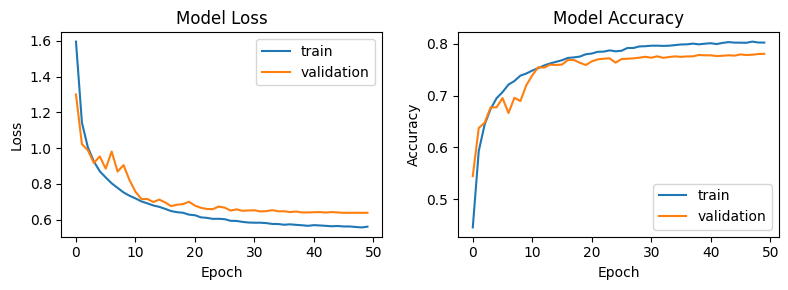

In [40]:
# history.history
# The history.history["loss"] entry is a dictionary with 50 values.
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)
df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)


fig, axes = plt.subplots(1, 2, figsize=(8, 3))
df_loss.plot(ax=axes[0], title='Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
df_acc.plot(ax=axes[1], title='Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.tight_layout()
plt.show()